# XAI Visualizations

In [1]:
# imports
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
import project.utils as utils
import project.config as config

from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from captum.attr import visualization as viz
from project.dataset import BeakDataModule, IDX_TO_CLASS
from project.beak_classifier import BeakClassifier

%matplotlib inline

## Gradcam Visualization

Helper routines

In [2]:
def load_heatmaps(path):
    f = h5py.File(path, 'r')
    heatmaps = f['heatmaps']
    return f, heatmaps

def load_model(path):
    model = BeakClassifier.load_from_checkpoint(
        path,
        config.DEVICE ).to( config.DEVICE )
    model.eval()
    return model

data_dir = '../../data/224Beaks'
batch_size, num_workers = 1, 0
dataModule = BeakDataModule(data_dir, batch_size, num_workers)
dataModule.setup()
test_dataloader = dataModule.test_dataloader()
model_path = 'lightning_logs/version_0/checkpoints/best_model.ckpt'
model = load_model(model_path)

path = 'lightning_logs/version_0/checkpoints/gradcam.h5'
f, heatmaps = load_heatmaps(path)
print(f'heatmaps shape: {heatmaps.shape}')

heatmaps shape: (2057, 224, 224)


Visualization

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


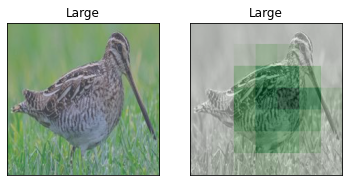

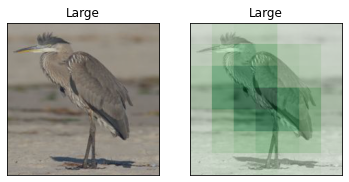

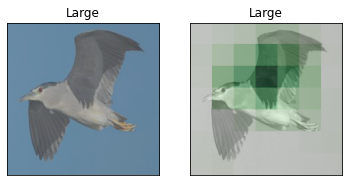

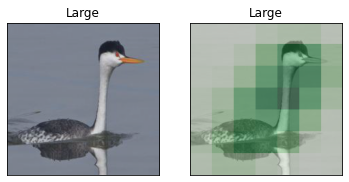

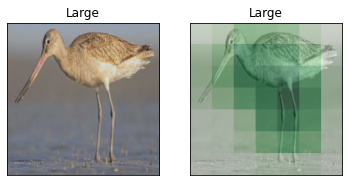

In [3]:
NUM_VIZ = 5

def plot_heatmaps(model, test_dataloader, heatmaps):
    num_seen = 0
    for batch_id, (img, label) in enumerate(test_dataloader):
        if num_seen >= NUM_VIZ: break
        if label[0].item() != 2: continue
        # import pdb; pdb.set_trace()
        img = img.to(config.DEVICE)
        pred = model.forward(img).argmax(dim=1)
        orig_img = img.cpu().squeeze().numpy().transpose([1, 2, 0])
        orig_img = utils.deprocess_image(orig_img)
        heatmap = np.expand_dims(heatmaps[batch_id], axis=-1)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        gt_label = IDX_TO_CLASS[label[0].item()]
        pred_label = IDX_TO_CLASS[pred[0].item()]
        viz.visualize_image_attr(None, orig_img, 
                method="original_image", title=f"{gt_label}",
                plt_fig_axis=(fig, ax1), use_pyplot=False)
        viz.visualize_image_attr(heatmap, orig_img, sign='positive',
                method="blended_heat_map", title=f"{pred_label}",
                plt_fig_axis=(fig, ax2), use_pyplot=False)
        num_seen += 1
        
    
plot_heatmaps(model, test_dataloader, heatmaps)

In [4]:
f.close()

## The End